In [1]:
import os
import os.path as op
import numpy as np
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import nibabel as nib
from scipy.stats import variation as cov

%matplotlib inline

plt.rcParams["font.size"] = "16"

/home/Gregory.Kiar/env/gp/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# Load files
fls = sorted(["./data/"+f for f in os.listdir('./data') if f.endswith('.csv')])

# Specify some parameters
diag_offset = 1  # Because we don't compute (i, i) ICC scores
num_rois = 200

parcellation_file = '/data/tmp/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_3mm.nii.gz'
parcellation_nii = nib.load(parcellation_file)
parcellation_data = parcellation_nii.get_fdata().astype(int)
aff = parcellation_nii.affine
hea = parcellation_nii.header

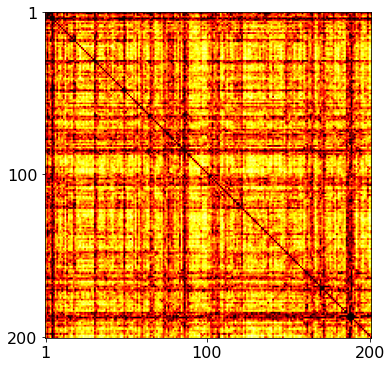

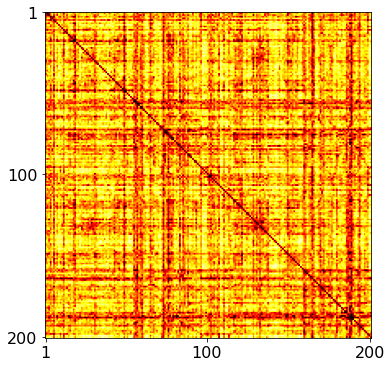

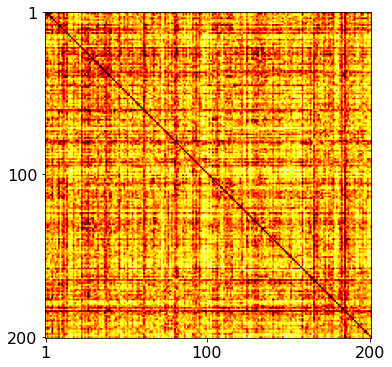

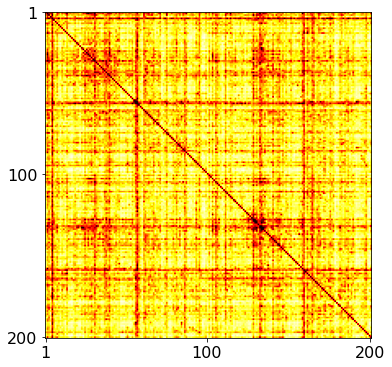

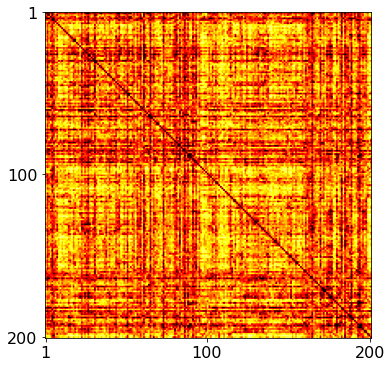

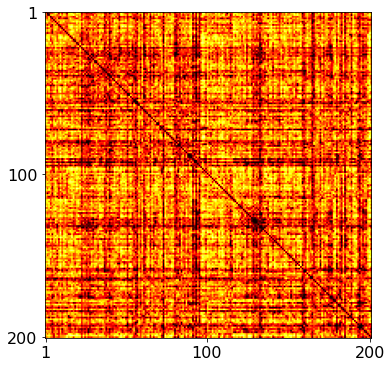

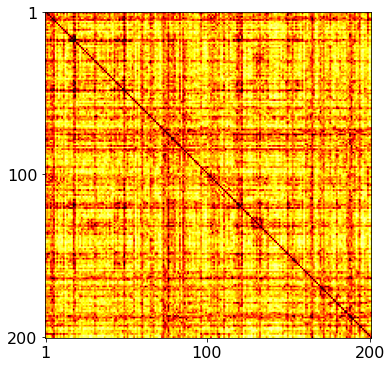

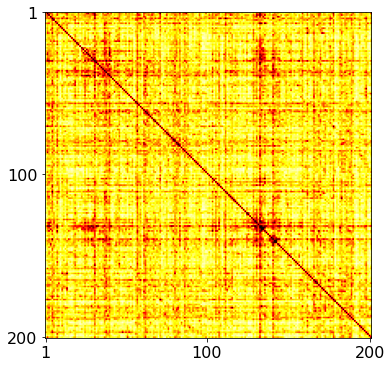

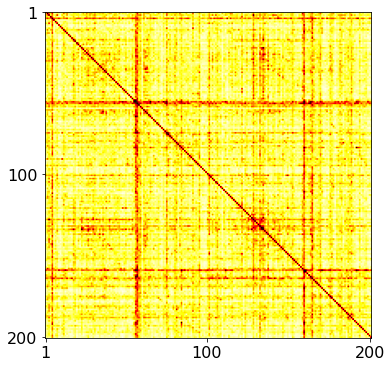

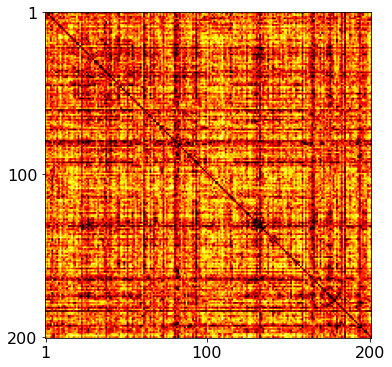

In [3]:
for fl in fls:
    # Load ICC data
    icc_list = np.loadtxt(fl)
    icc_mat = np.zeros((num_rois, num_rois))
    triu_locs = np.triu_indices(num_rois, k=diag_offset)
    
    # Construct ICC matrices
    icc_mat[triu_locs] = icc_list
    icc_mat += icc_mat.T
    
    # Vizualize ICC as a matrix
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(icc_mat, cmap=mpl.cm.hot)
    plt.clim([0, 1])
    plt.xticks([0, 99, 199], [1, 100, 200])
    plt.yticks([0, 99, 199], [1, 100, 200])
    plt.savefig(fl.replace('.csv', '_matrix.png').replace('data', 'figs'), facecolor='white', bbox_inches='tight', transparent=False)
    
    # Visualize ICC on the template
    # COV
    cov_iccs = cov(icc_mat, axis=0)    
    icc_template = np.copy(parcellation_data).astype(np.float32)
    for r in range(1, num_rois+1):
        icc_template[np.where(parcellation_data == r)] = cov_iccs[r-1]

    icc_nii = nib.Nifti1Image(icc_template, aff, hea)
    plotting.plot_glass_brain(icc_nii, symmetric_cbar=False, colorbar=False,
                              vmax=1, draw_cross=False, annotate=False,
                              cmap=mpl.cm.hot,
                              output_file=fl.replace('.csv', '_cov_brain.png').replace('data','figs'))
    
    del icc_template, icc_nii, cov_iccs
    # AVG
    avg_iccs = np.mean(icc_mat, axis=0)
    icc_template = np.copy(parcellation_data).astype(np.float32)
    for r in range(1, num_rois+1):
        icc_template[np.where(parcellation_data == r)] = avg_iccs[r-1]

    icc_nii = nib.Nifti1Image(icc_template, aff, hea)
    plotting.plot_glass_brain(icc_nii, symmetric_cbar=False, colorbar=False,
                              vmax=1, draw_cross=False, annotate=False,
                              cmap=mpl.cm.hot,
                              output_file=fl.replace('.csv', '_avg_brain.png').replace('data', 'figs'))

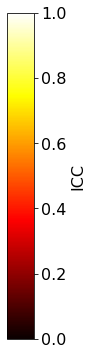

In [4]:
fig, ax = plt.subplots(figsize=(1, 6))
fig.subplots_adjust(right=0.5)

cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm)
cb1.set_label('ICC')
fig.savefig('./figs/colorbar.png', facecolor='white', bbox_inches='tight', transparent=False)